In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneGroupOut

In [38]:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    return df

In [39]:
SIGNAL_CATEGORIES = {
    'ECG': ['HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'],
    'PPG': ['PPG_HR_mean','PPG_HR_std','PPG_RMSSD','PPG_SDNN','PPG_LF','PPG_HF','PPG_LF_HF','PPG_num_beats','PPG_RiseTime','PPG_DecayTime','PPG_PAV_mean','PPG_PAV_std','PPG_RI'],
    'EDA': ['EDA_mean','EDA_std','EDA_min','EDA_max','EDA_range','EDA_slope','scl_mean','scl_std','scr_mean','scr_std','corr_scl_t','scr_count','scr_amp','scr_sum','scr_area'],
    'RESP': ['Resp_mean','Resp_std','Resp_I_mean','Resp_I_std','Resp_E_mean','Resp_E_std','Resp_IE_ratio','Resp_range','Resp_insp_vol','Resp_rate','Resp_duration'],
}
random = 13577

In [40]:
def calculate_metrics(y_true, y_pred, stage):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Valor": [accuracy, precision, recall, f1],
        "Etapa": stage
    })
    
    print(f"{stage} Metrics")
    print(metrics_table)
    return metrics_table

In [41]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"{title} - Confusion Matrix")
    print(conf_mat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", xticklabels=set(y_true), yticklabels=set(y_true), fmt='g')
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas verdaderas")
    plt.title(f'Matriz de confusión - {title}')
    plt.show()

In [42]:
def train_and_evaluate(X, y, model, param_grid, model_name, signal_name):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random, stratify=y)
    
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=16, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]
    
    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    print(classification_report(y_test, y_pred))

    return metrics


In [43]:
models = {
    "DecisionTree": (
        DecisionTreeClassifier(class_weight='balanced', random_state=random),
        {"max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10], 
        "max_leaf_nodes": [10, 15, 20, 30, 40],
        "criterion": ["gini", "entropy"]}
    ),
    "RandomForest": (
    RandomForestClassifier(class_weight='balanced', random_state=random),
    {"n_estimators": [100, 200, 300],
     "max_depth": [None, 10, 20],
     "min_samples_split": [2, 5, 10]}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=random),
        {"n_estimators": [50, 100, 200, 300], 
        "learning_rate": [0.01, 0.1, 0.5, 1], 
        "estimator": [DecisionTreeClassifier(max_depth=1), 
                            DecisionTreeClassifier(max_depth=3)]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {"solver": ["svd"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    )
}

results = {}

In [44]:
file = r'features_30_075\features.csv'

df = load_data(file)
df = df.fillna(0)

In [45]:
df.columns

Index(['HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF',
       'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm', 'PPG_HR_mean',
       'PPG_HR_std', 'PPG_RMSSD', 'PPG_SDNN', 'PPG_LF', 'PPG_HF', 'PPG_LF_HF',
       'PPG_num_beats', 'PPG_RiseTime', 'PPG_DecayTime', 'PPG_PAV_mean',
       'PPG_PAV_std', 'PPG_RI', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max',
       'EDA_range', 'EDA_slope', 'scl_mean', 'scl_std', 'scr_mean', 'scr_std',
       'corr_scl_t', 'scr_count', 'scr_amp', 'scr_sum', 'scr_area',
       'Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std', 'Resp_E_mean',
       'Resp_E_std', 'Resp_IE_ratio', 'Resp_range', 'Resp_insp_vol',
       'Resp_rate', 'Resp_duration', 'subject', 'label'],
      dtype='object')

In [46]:
print("Valores nulos por columna:\n", df.isna().sum())

Valores nulos por columna:
 HR_mean          0
HR_std           0
NN50             0
pNN50            0
TINN             0
rmsHRV           0
LF               0
HF               0
LF_HF            0
sum_f            0
rel_f            0
LF_norm          0
HF_norm          0
PPG_HR_mean      0
PPG_HR_std       0
PPG_RMSSD        0
PPG_SDNN         0
PPG_LF           0
PPG_HF           0
PPG_LF_HF        0
PPG_num_beats    0
PPG_RiseTime     0
PPG_DecayTime    0
PPG_PAV_mean     0
PPG_PAV_std      0
PPG_RI           0
EDA_mean         0
EDA_std          0
EDA_min          0
EDA_max          0
EDA_range        0
EDA_slope        0
scl_mean         0
scl_std          0
scr_mean         0
scr_std          0
corr_scl_t       0
scr_count        0
scr_amp          0
scr_sum          0
scr_area         0
Resp_mean        0
Resp_std         0
Resp_I_mean      0
Resp_I_std       0
Resp_E_mean      0
Resp_E_std       0
Resp_IE_ratio    0
Resp_range       0
Resp_insp_vol    0
Resp_rate        0
Res

In [25]:
results['ECG', 'DecisionTree']

,Métrica,Valor,Etapa
0,Accuracy,0.555774,ECG - DecisionTree
1,Precision,0.549138,ECG - DecisionTree
2,Recall,0.555774,ECG - DecisionTree
3,F1 Score,0.549893,ECG - DecisionTree


Training by signal:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ECG...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
ECG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.557368  ECG - DecisionTree
1  Precision  0.567214  ECG - DecisionTree
2     Recall  0.557368  ECG - DecisionTree
3   F1 Score  0.557150  ECG - DecisionTree
[ECG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[ECG - DecisionTree] Accuracy: 0.5574
ECG - DecisionTree - Confusion Matrix
[[2905  514  970]
 [1018 1655  877]
 [ 860  483 1386]]


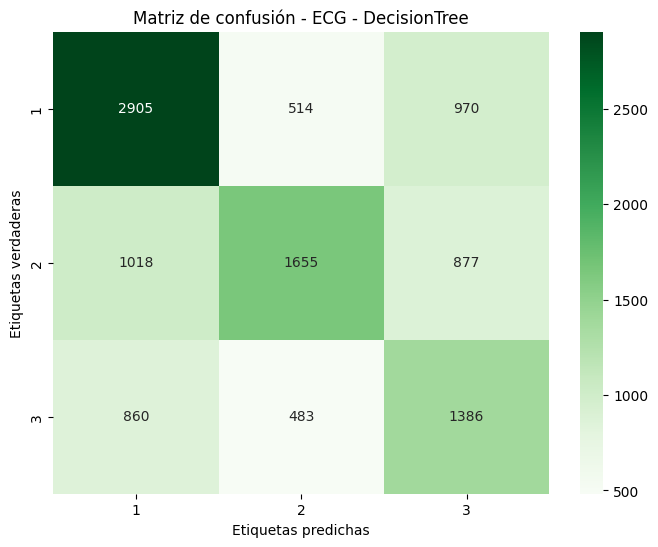

              precision    recall  f1-score   support

           1       0.61      0.66      0.63      4389
           2       0.62      0.47      0.53      3550
           3       0.43      0.51      0.46      2729

    accuracy                           0.56     10668
   macro avg       0.55      0.55      0.54     10668
weighted avg       0.57      0.56      0.56     10668

Training RandomForest model for ECG...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
ECG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.935039  ECG - RandomForest
1  Precision  0.935989  ECG - RandomForest
2     Recall  0.935039  ECG - RandomForest
3   F1 Score  0.934815  ECG - RandomForest
[ECG - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[ECG - RandomForest] Accuracy: 0.9350
ECG - RandomForest - Confusion Matrix
[[4265   77   47]
 [ 185 3289   76]
 [ 214   94 2421]]


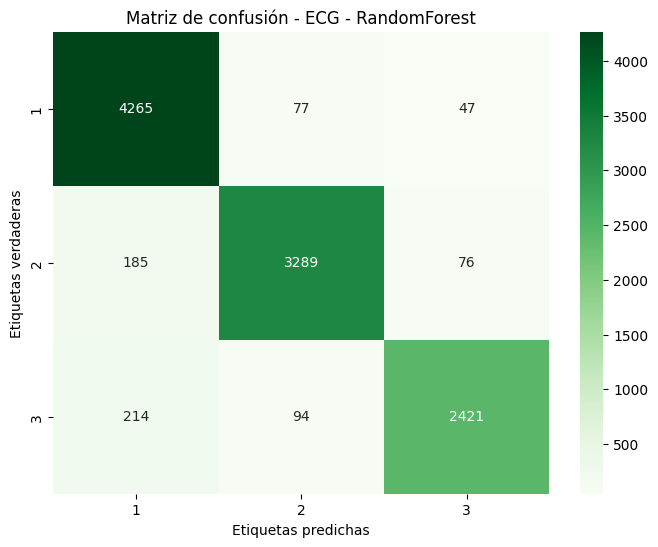

              precision    recall  f1-score   support

           1       0.91      0.97      0.94      4389
           2       0.95      0.93      0.94      3550
           3       0.95      0.89      0.92      2729

    accuracy                           0.94     10668
   macro avg       0.94      0.93      0.93     10668
weighted avg       0.94      0.94      0.93     10668

Training AdaBoost model for ECG...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ECG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.714567  ECG - AdaBoost
1  Precision  0.713845  ECG - AdaBoost
2     Recall  0.714567  ECG - AdaBoost
3   F1 Score  0.710503  ECG - AdaBoost
[ECG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ECG - AdaBoost] Accuracy: 0.7146
ECG - AdaBoost - Confusion Matrix
[[3628  464  297]
 [ 758 2463  329]
 [ 641  556 1532]]


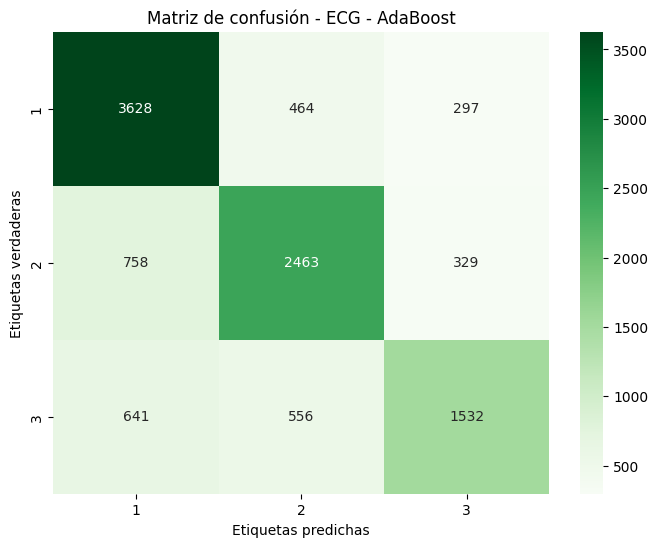

              precision    recall  f1-score   support

           1       0.72      0.83      0.77      4389
           2       0.71      0.69      0.70      3550
           3       0.71      0.56      0.63      2729

    accuracy                           0.71     10668
   macro avg       0.71      0.69      0.70     10668
weighted avg       0.71      0.71      0.71     10668

Training LDA model for ECG...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ECG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.508624  ECG - LDA
1  Precision  0.494030  ECG - LDA
2     Recall  0.508624  ECG - LDA
3   F1 Score  0.470204  ECG - LDA
[ECG - LDA] Best Params: {'solver': 'svd'}
[ECG - LDA] Accuracy: 0.5086
ECG - LDA - Confusion Matrix
[[3546  587  256]
 [1775 1451  324]
 [1542  758  429]]


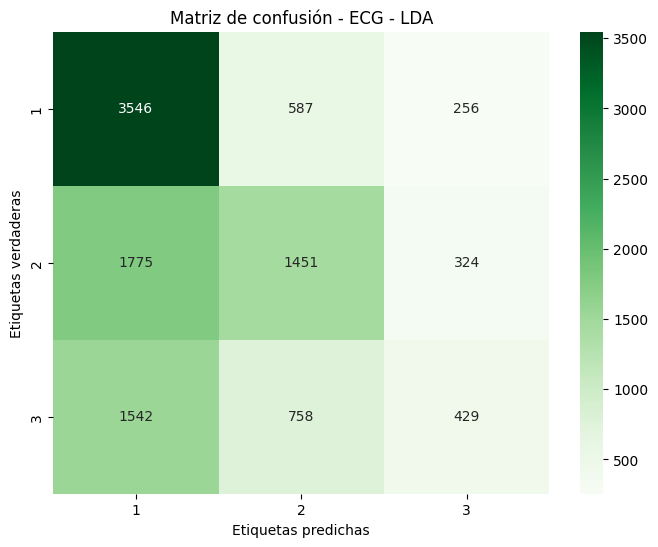

              precision    recall  f1-score   support

           1       0.52      0.81      0.63      4389
           2       0.52      0.41      0.46      3550
           3       0.43      0.16      0.23      2729

    accuracy                           0.51     10668
   macro avg       0.49      0.46      0.44     10668
weighted avg       0.49      0.51      0.47     10668

Training KNN model for ECG...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ECG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.633390  ECG - KNN
1  Precision  0.630614  ECG - KNN
2     Recall  0.633390  ECG - KNN
3   F1 Score  0.630667  ECG - KNN
[ECG - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[ECG - KNN] Accuracy: 0.6334
ECG - KNN - Confusion Matrix
[[3211  672  506]
 [ 878 2146  526]
 [ 771  558 1400]]


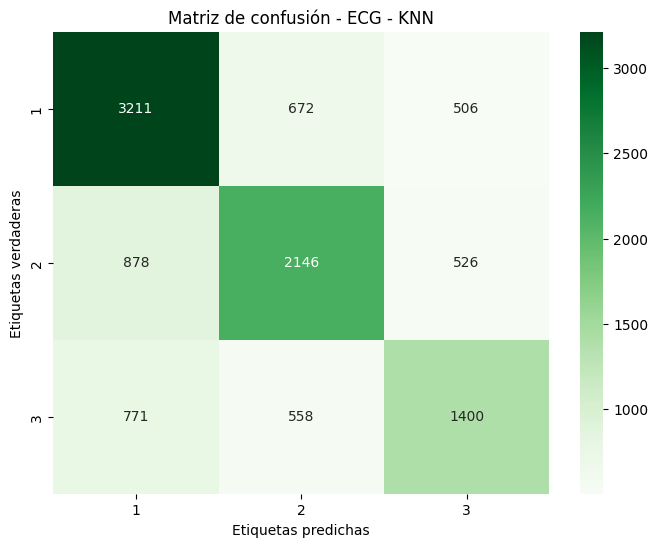

Training by signal:  25%|██▌       | 1/4 [22:45<1:08:15, 1365.22s/it]

              precision    recall  f1-score   support

           1       0.66      0.73      0.69      4389
           2       0.64      0.60      0.62      3550
           3       0.58      0.51      0.54      2729

    accuracy                           0.63     10668
   macro avg       0.62      0.62      0.62     10668
weighted avg       0.63      0.63      0.63     10668

Training DecisionTree model for PPG...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
PPG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.768841  PPG - DecisionTree
1  Precision  0.776933  PPG - DecisionTree
2     Recall  0.768841  PPG - DecisionTree
3   F1 Score  0.772047  PPG - DecisionTree
[PPG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[PPG - DecisionTree] Accuracy: 0.7688
PPG - DecisionTree - Confusion Matrix
[[3650  148  591]
 [ 168 2755  627]
 [ 272  660 1797]]


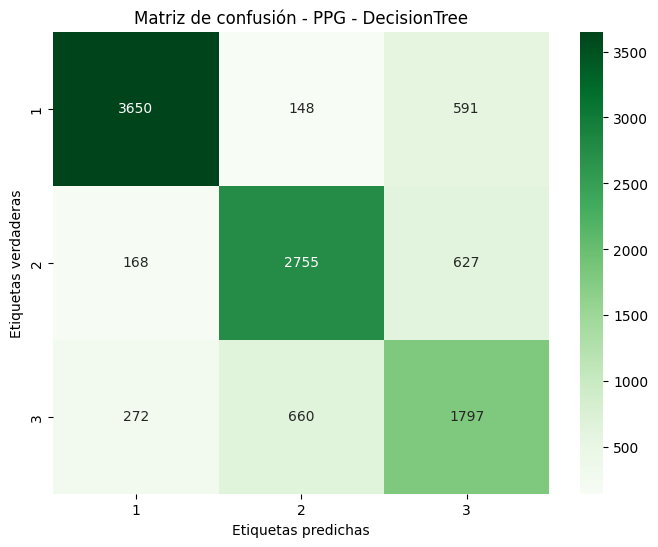

              precision    recall  f1-score   support

           1       0.89      0.83      0.86      4389
           2       0.77      0.78      0.77      3550
           3       0.60      0.66      0.63      2729

    accuracy                           0.77     10668
   macro avg       0.75      0.76      0.75     10668
weighted avg       0.78      0.77      0.77     10668

Training RandomForest model for PPG...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
PPG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.990626  PPG - RandomForest
1  Precision  0.990617  PPG - RandomForest
2     Recall  0.990626  PPG - RandomForest
3   F1 Score  0.990616  PPG - RandomForest
[PPG - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[PPG - RandomForest] Accuracy: 0.9906
PPG - RandomForest - Confusion Matrix
[[4376    4    9]
 [  10 3516   24]
 [  22   31 2676]]


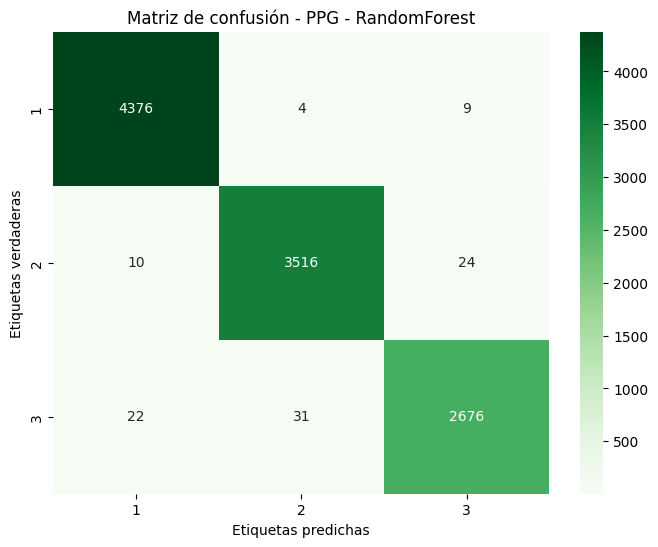

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      4389
           2       0.99      0.99      0.99      3550
           3       0.99      0.98      0.98      2729

    accuracy                           0.99     10668
   macro avg       0.99      0.99      0.99     10668
weighted avg       0.99      0.99      0.99     10668

Training AdaBoost model for PPG...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
PPG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.865579  PPG - AdaBoost
1  Precision  0.868857  PPG - AdaBoost
2     Recall  0.865579  PPG - AdaBoost
3   F1 Score  0.866981  PPG - AdaBoost
[PPG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[PPG - AdaBoost] Accuracy: 0.8656
PPG - AdaBoost - Confusion Matrix
[[4152   38  199]
 [  24 2968  558]
 [  67  548 2114]]


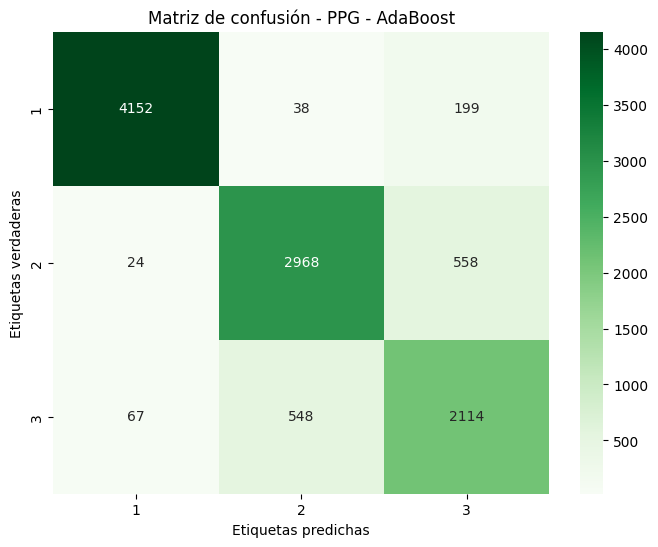

              precision    recall  f1-score   support

           1       0.98      0.95      0.96      4389
           2       0.84      0.84      0.84      3550
           3       0.74      0.77      0.76      2729

    accuracy                           0.87     10668
   macro avg       0.85      0.85      0.85     10668
weighted avg       0.87      0.87      0.87     10668

Training LDA model for PPG...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
PPG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.665354  PPG - LDA
1  Precision  0.666718  PPG - LDA
2     Recall  0.665354  PPG - LDA
3   F1 Score  0.665476  PPG - LDA
[PPG - LDA] Best Params: {'solver': 'svd'}
[PPG - LDA] Accuracy: 0.6654
PPG - LDA - Confusion Matrix
[[3438  251  700]
 [ 235 2516  799]
 [ 513 1072 1144]]


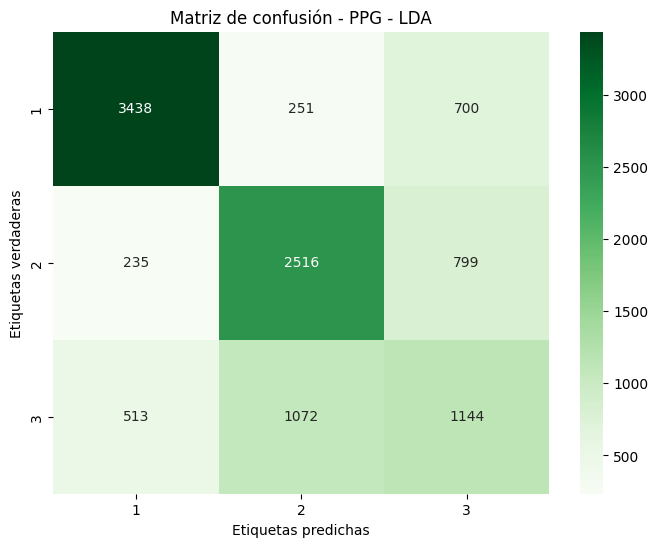

              precision    recall  f1-score   support

           1       0.82      0.78      0.80      4389
           2       0.66      0.71      0.68      3550
           3       0.43      0.42      0.43      2729

    accuracy                           0.67     10668
   macro avg       0.64      0.64      0.64     10668
weighted avg       0.67      0.67      0.67     10668

Training KNN model for PPG...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
PPG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.884327  PPG - KNN
1  Precision  0.884200  PPG - KNN
2     Recall  0.884327  PPG - KNN
3   F1 Score  0.884255  PPG - KNN
[PPG - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[PPG - KNN] Accuracy: 0.8843
PPG - KNN - Confusion Matrix
[[4046  144  199]
 [ 136 3149  265]
 [ 207  283 2239]]


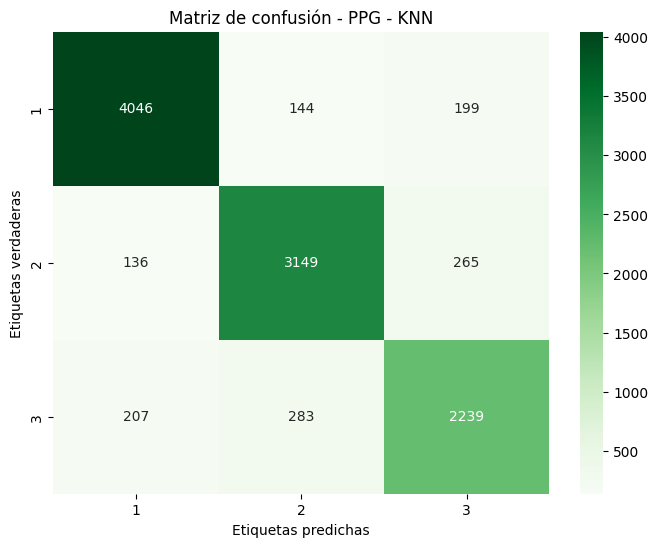

Training by signal:  50%|█████     | 2/4 [45:19<45:17, 1359.00s/it]  

              precision    recall  f1-score   support

           1       0.92      0.92      0.92      4389
           2       0.88      0.89      0.88      3550
           3       0.83      0.82      0.82      2729

    accuracy                           0.88     10668
   macro avg       0.88      0.88      0.88     10668
weighted avg       0.88      0.88      0.88     10668

Training DecisionTree model for EDA...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.674822  EDA - DecisionTree
1  Precision  0.687952  EDA - DecisionTree
2     Recall  0.674822  EDA - DecisionTree
3   F1 Score  0.679303  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[EDA - DecisionTree] Accuracy: 0.6748
EDA - DecisionTree - Confusion Matrix
[[3201  695  493]
 [ 355 2296  899]
 [ 294  733 1702]]


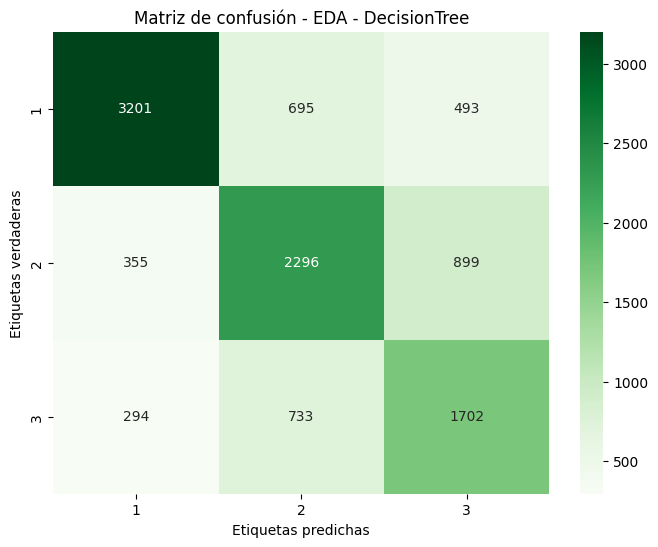

              precision    recall  f1-score   support

           1       0.83      0.73      0.78      4389
           2       0.62      0.65      0.63      3550
           3       0.55      0.62      0.58      2729

    accuracy                           0.67     10668
   macro avg       0.67      0.67      0.66     10668
weighted avg       0.69      0.67      0.68     10668

Training RandomForest model for EDA...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.985096  EDA - RandomForest
1  Precision  0.985095  EDA - RandomForest
2     Recall  0.985096  EDA - RandomForest
3   F1 Score  0.985095  EDA - RandomForest
[EDA - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[EDA - RandomForest] Accuracy: 0.9851
EDA - RandomForest - Confusion Matrix
[[4343   24   22]
 [  29 3489   32]
 [  22   30 2677]]


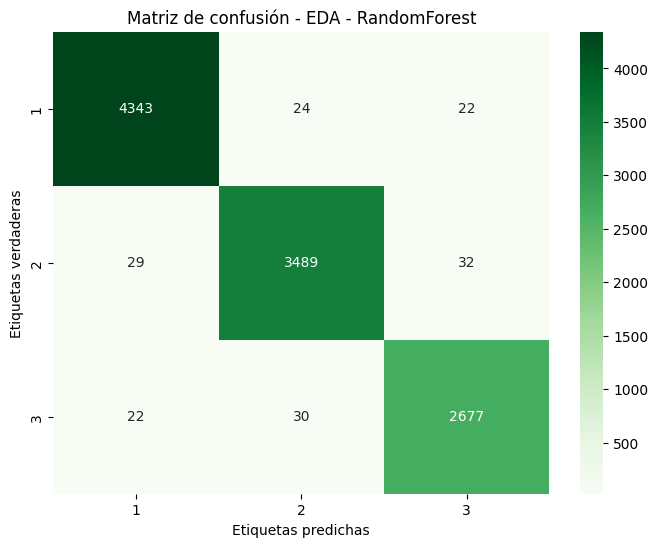

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4389
           2       0.98      0.98      0.98      3550
           3       0.98      0.98      0.98      2729

    accuracy                           0.99     10668
   macro avg       0.98      0.98      0.98     10668
weighted avg       0.99      0.99      0.99     10668

Training AdaBoost model for EDA...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.854706  EDA - AdaBoost
1  Precision  0.859174  EDA - AdaBoost
2     Recall  0.854706  EDA - AdaBoost
3   F1 Score  0.855723  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[EDA - AdaBoost] Accuracy: 0.8547
EDA - AdaBoost - Confusion Matrix
[[3997  192  200]
 [ 163 2807  580]
 [ 105  310 2314]]


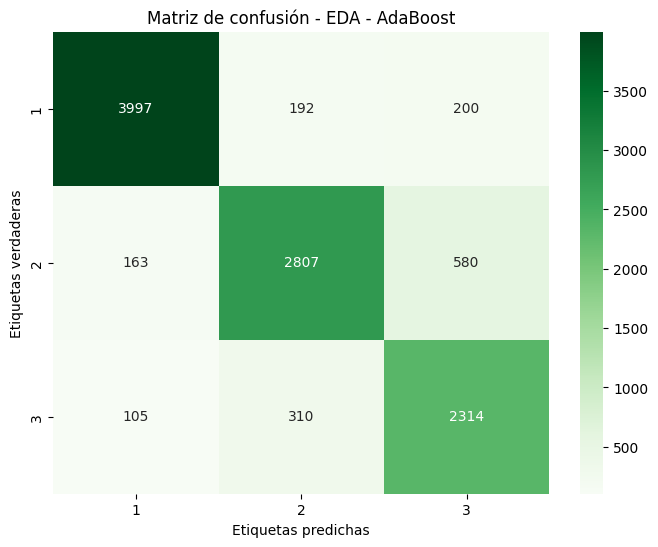

              precision    recall  f1-score   support

           1       0.94      0.91      0.92      4389
           2       0.85      0.79      0.82      3550
           3       0.75      0.85      0.79      2729

    accuracy                           0.85     10668
   macro avg       0.84      0.85      0.85     10668
weighted avg       0.86      0.85      0.86     10668

Training LDA model for EDA...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.493813  EDA - LDA
1  Precision  0.471514  EDA - LDA
2     Recall  0.493813  EDA - LDA
3   F1 Score  0.457556  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.4938
EDA - LDA - Confusion Matrix
[[3363  645  381]
 [1790 1520  240]
 [1389  955  385]]


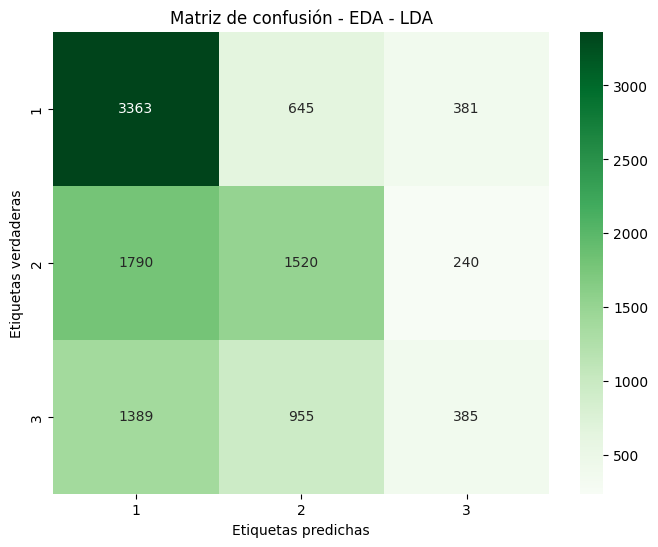

              precision    recall  f1-score   support

           1       0.51      0.77      0.62      4389
           2       0.49      0.43      0.46      3550
           3       0.38      0.14      0.21      2729

    accuracy                           0.49     10668
   macro avg       0.46      0.45      0.43     10668
weighted avg       0.47      0.49      0.46     10668

Training KNN model for EDA...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.921729  EDA - KNN
1  Precision  0.921955  EDA - KNN
2     Recall  0.921729  EDA - KNN
3   F1 Score  0.921807  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[EDA - KNN] Accuracy: 0.9217
EDA - KNN - Confusion Matrix
[[4093  173  123]
 [ 131 3270  149]
 [ 103  156 2470]]


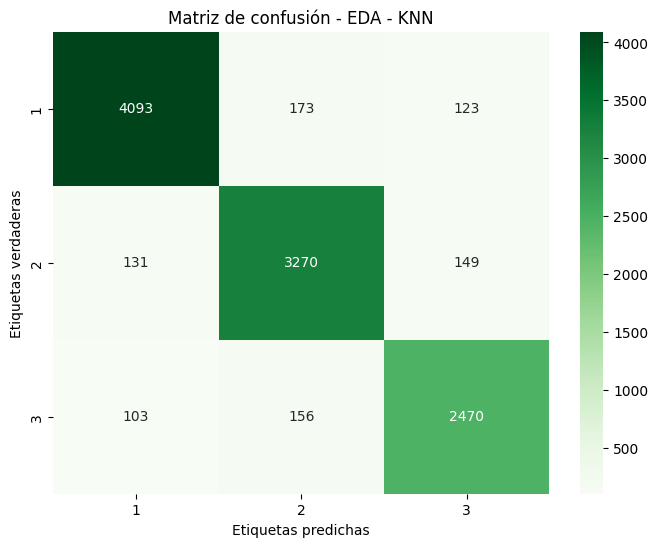

Training by signal:  75%|███████▌  | 3/4 [1:03:10<20:27, 1227.27s/it]

              precision    recall  f1-score   support

           1       0.95      0.93      0.94      4389
           2       0.91      0.92      0.91      3550
           3       0.90      0.91      0.90      2729

    accuracy                           0.92     10668
   macro avg       0.92      0.92      0.92     10668
weighted avg       0.92      0.92      0.92     10668

Training DecisionTree model for RESP...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.574241  RESP - DecisionTree
1  Precision  0.595887  RESP - DecisionTree
2     Recall  0.574241  RESP - DecisionTree
3   F1 Score  0.573883  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[RESP - DecisionTree] Accuracy: 0.5742
RESP - DecisionTree - Confusion Matrix
[[2230 1387  772]
 [ 512 2490  548]
 [ 412  911 1406]]


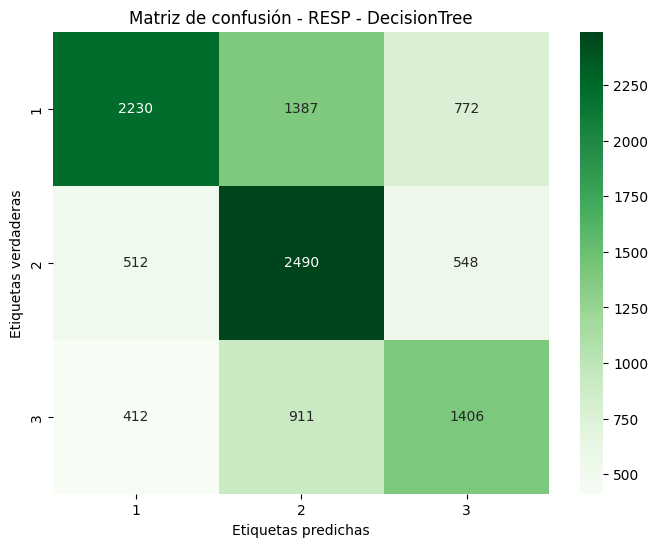

              precision    recall  f1-score   support

           1       0.71      0.51      0.59      4389
           2       0.52      0.70      0.60      3550
           3       0.52      0.52      0.52      2729

    accuracy                           0.57     10668
   macro avg       0.58      0.57      0.57     10668
weighted avg       0.60      0.57      0.57     10668

Training RandomForest model for RESP...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.981065  RESP - RandomForest
1  Precision  0.981111  RESP - RandomForest
2     Recall  0.981065  RESP - RandomForest
3   F1 Score  0.981049  RESP - RandomForest
[RESP - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[RESP - RandomForest] Accuracy: 0.9811
RESP - RandomForest - Confusion Matrix
[[4340   35   14]
 [  43 3488   19]
 [  42   49 2638]]


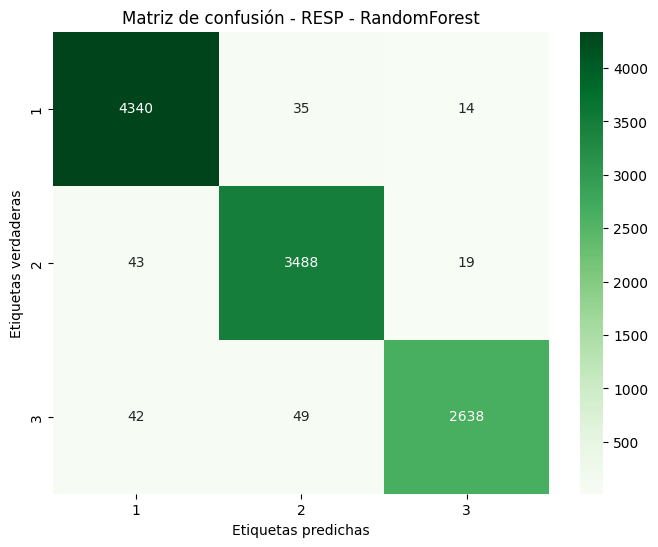

              precision    recall  f1-score   support

           1       0.98      0.99      0.98      4389
           2       0.98      0.98      0.98      3550
           3       0.99      0.97      0.98      2729

    accuracy                           0.98     10668
   macro avg       0.98      0.98      0.98     10668
weighted avg       0.98      0.98      0.98     10668

Training AdaBoost model for RESP...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.787027  RESP - AdaBoost
1  Precision  0.787356  RESP - AdaBoost
2     Recall  0.787027  RESP - AdaBoost
3   F1 Score  0.786150  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[RESP - AdaBoost] Accuracy: 0.7870
RESP - AdaBoost - Confusion Matrix
[[3685  395  309]
 [ 582 2778  190]
 [ 438  358 1933]]


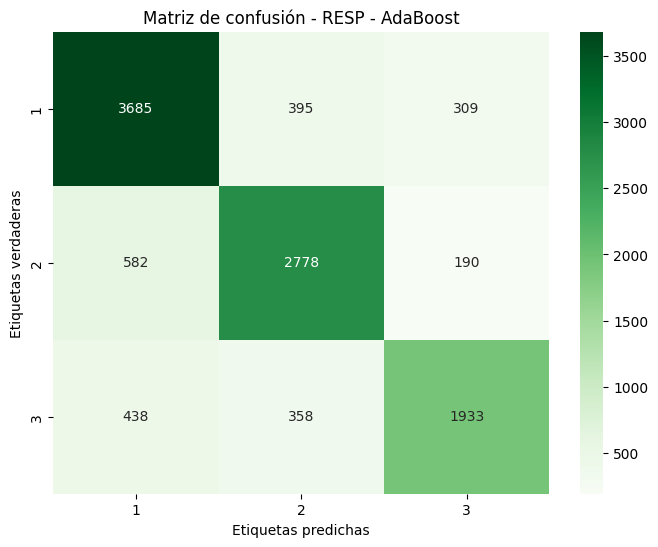

              precision    recall  f1-score   support

           1       0.78      0.84      0.81      4389
           2       0.79      0.78      0.78      3550
           3       0.79      0.71      0.75      2729

    accuracy                           0.79     10668
   macro avg       0.79      0.78      0.78     10668
weighted avg       0.79      0.79      0.79     10668

Training LDA model for RESP...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.507499  RESP - LDA
1  Precision  0.485270  RESP - LDA
2     Recall  0.507499  RESP - LDA
3   F1 Score  0.454819  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.5075
RESP - LDA - Confusion Matrix
[[3245  984  160]
 [1455 2004   91]
 [1841  723  165]]


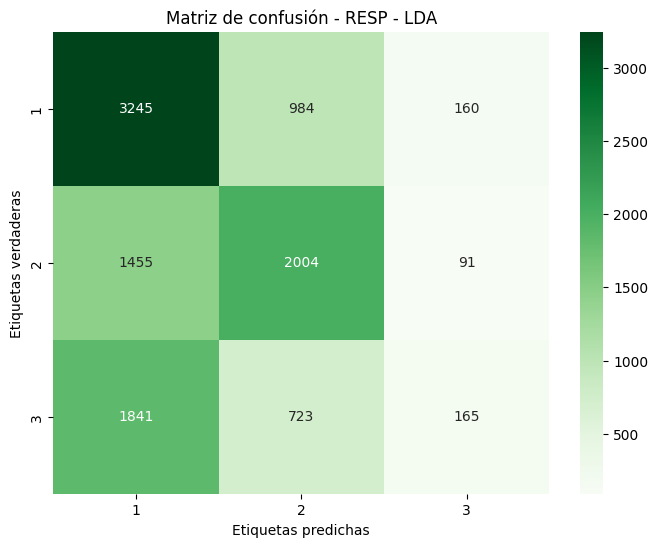

              precision    recall  f1-score   support

           1       0.50      0.74      0.59      4389
           2       0.54      0.56      0.55      3550
           3       0.40      0.06      0.10      2729

    accuracy                           0.51     10668
   macro avg       0.48      0.45      0.42     10668
weighted avg       0.49      0.51      0.45     10668

Training KNN model for RESP...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.972347  RESP - KNN
1  Precision  0.972338  RESP - KNN
2     Recall  0.972347  RESP - KNN
3   F1 Score  0.972339  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[RESP - KNN] Accuracy: 0.9723
RESP - KNN - Confusion Matrix
[[4295   50   44]
 [  57 3450   43]
 [  54   47 2628]]


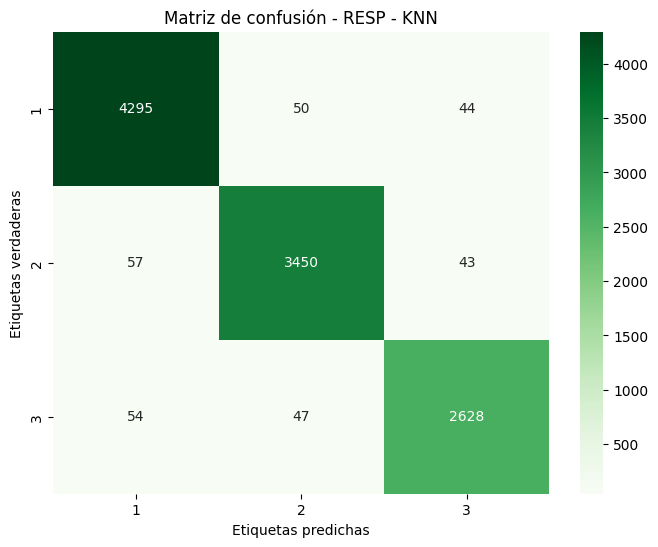

Training by signal: 100%|██████████| 4/4 [1:19:14<00:00, 1188.57s/it]


              precision    recall  f1-score   support

           1       0.97      0.98      0.98      4389
           2       0.97      0.97      0.97      3550
           3       0.97      0.96      0.97      2729

    accuracy                           0.97     10668
   macro avg       0.97      0.97      0.97     10668
weighted avg       0.97      0.97      0.97     10668



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.574241  ALL - DecisionTree
1  Precision  0.595887  ALL - DecisionTree
2     Recall  0.574241  ALL - DecisionTree
3   F1 Score  0.573883  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.5742
ALL - DecisionTree - Confusion Matrix
[[2230 1387  772]
 [ 512 2490  548]
 [ 412  911 1406]]


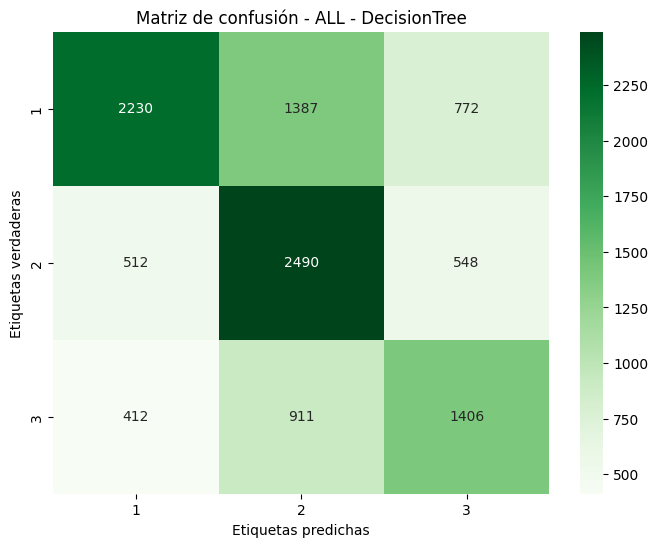

Training with ALL signals:  20%|██        | 1/5 [00:16<01:07, 16.95s/it]

              precision    recall  f1-score   support

           1       0.71      0.51      0.59      4389
           2       0.52      0.70      0.60      3550
           3       0.52      0.52      0.52      2729

    accuracy                           0.57     10668
   macro avg       0.58      0.57      0.57     10668
weighted avg       0.60      0.57      0.57     10668

Training RandomForest model for ALL signals using LOSO...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.981065  ALL - RandomForest
1  Precision  0.981111  ALL - RandomForest
2     Recall  0.981065  ALL - RandomForest
3   F1 Score  0.981049  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.9811
ALL - RandomForest - Confusion Matrix
[[4340   35   14]
 [  43 3488   19]
 [  42   49 2638]]


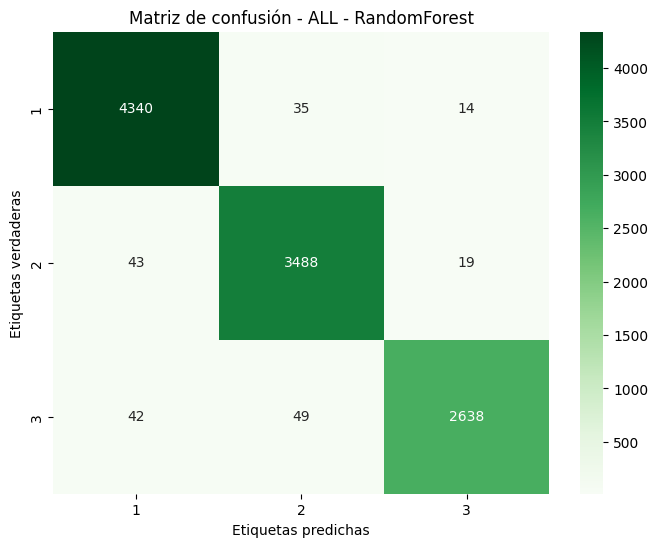

Training with ALL signals:  40%|████      | 2/5 [09:00<15:44, 314.70s/it]

              precision    recall  f1-score   support

           1       0.98      0.99      0.98      4389
           2       0.98      0.98      0.98      3550
           3       0.99      0.97      0.98      2729

    accuracy                           0.98     10668
   macro avg       0.98      0.98      0.98     10668
weighted avg       0.98      0.98      0.98     10668

Training AdaBoost model for ALL signals using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.787027  ALL - AdaBoost
1  Precision  0.787356  ALL - AdaBoost
2     Recall  0.787027  ALL - AdaBoost
3   F1 Score  0.786150  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.7870
ALL - AdaBoost - Confusion Matrix
[[3685  395  309]
 [ 582 2778  190]
 [ 438  358 1933]]


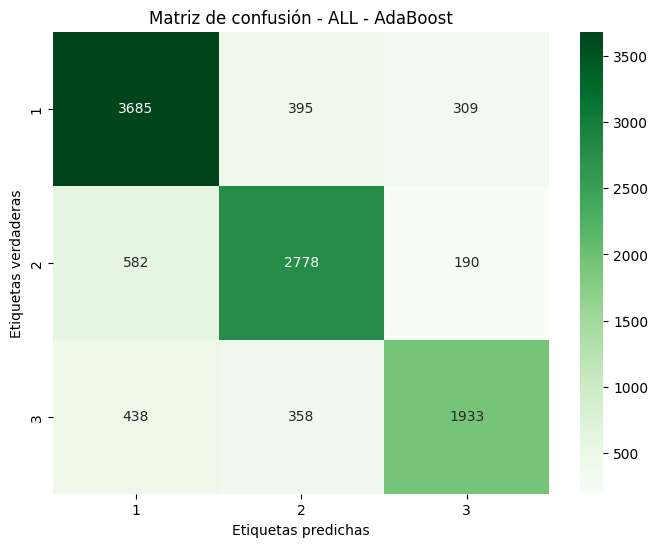

Training with ALL signals:  60%|██████    | 3/5 [16:15<12:19, 369.94s/it]

              precision    recall  f1-score   support

           1       0.78      0.84      0.81      4389
           2       0.79      0.78      0.78      3550
           3       0.79      0.71      0.75      2729

    accuracy                           0.79     10668
   macro avg       0.79      0.78      0.78     10668
weighted avg       0.79      0.79      0.79     10668

Training LDA model for ALL signals using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.507499  ALL - LDA
1  Precision  0.485270  ALL - LDA
2     Recall  0.507499  ALL - LDA
3   F1 Score  0.454819  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.5075
ALL - LDA - Confusion Matrix
[[3245  984  160]
 [1455 2004   91]
 [1841  723  165]]


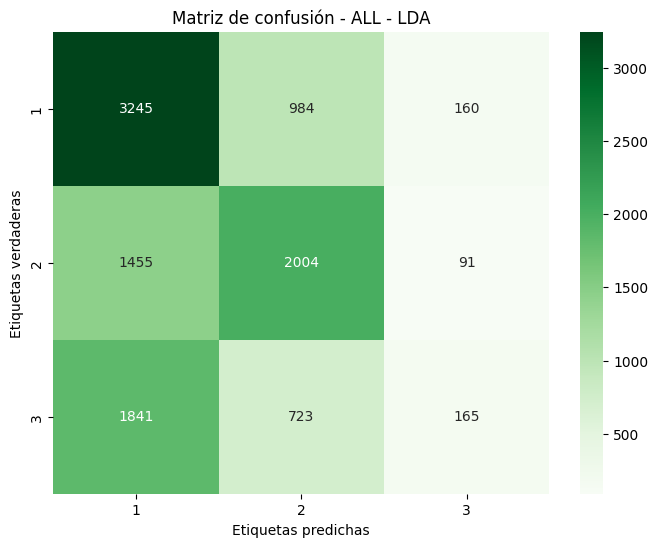

Training with ALL signals:  80%|████████  | 4/5 [16:16<03:44, 224.03s/it]

              precision    recall  f1-score   support

           1       0.50      0.74      0.59      4389
           2       0.54      0.56      0.55      3550
           3       0.40      0.06      0.10      2729

    accuracy                           0.51     10668
   macro avg       0.48      0.45      0.42     10668
weighted avg       0.49      0.51      0.45     10668

Training KNN model for ALL signals using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.972347  ALL - KNN
1  Precision  0.972338  ALL - KNN
2     Recall  0.972347  ALL - KNN
3   F1 Score  0.972339  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.9723
ALL - KNN - Confusion Matrix
[[4295   50   44]
 [  57 3450   43]
 [  54   47 2628]]


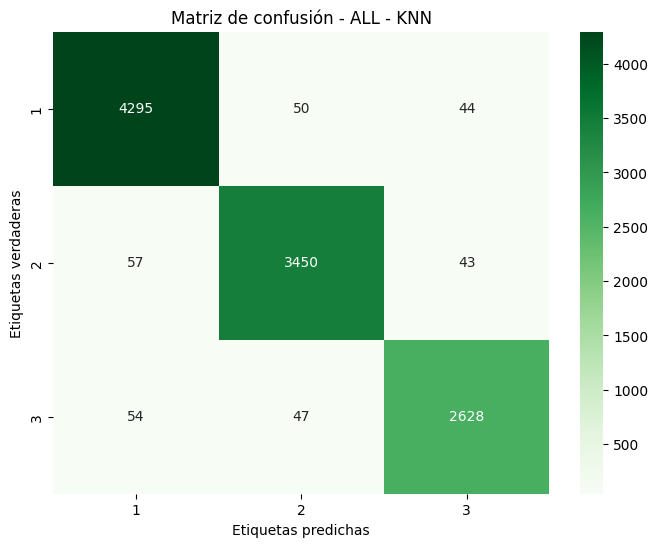

Training with ALL signals: 100%|██████████| 5/5 [16:17<00:00, 195.47s/it]

              precision    recall  f1-score   support

           1       0.97      0.98      0.98      4389
           2       0.97      0.97      0.97      3550
           3       0.97      0.96      0.97      2729

    accuracy                           0.97     10668
   macro avg       0.97      0.97      0.97     10668
weighted avg       0.97      0.97      0.97     10668


Final Comparison:
ECG - DecisionTree:      Métrica     Valor               Etapa
0   Accuracy  0.557368  ECG - DecisionTree
1  Precision  0.567214  ECG - DecisionTree
2     Recall  0.557368  ECG - DecisionTree
3   F1 Score  0.557150  ECG - DecisionTree
ECG - RandomForest:      Métrica     Valor               Etapa
0   Accuracy  0.935039  ECG - RandomForest
1  Precision  0.935989  ECG - RandomForest
2     Recall  0.935039  ECG - RandomForest
3   F1 Score  0.934815  ECG - RandomForest
ECG - AdaBoost:      Métrica     Valor           Etapa
0   Accuracy  0.714567  ECG - AdaBoost
1  Precision  0.713845  ECG - AdaBoo

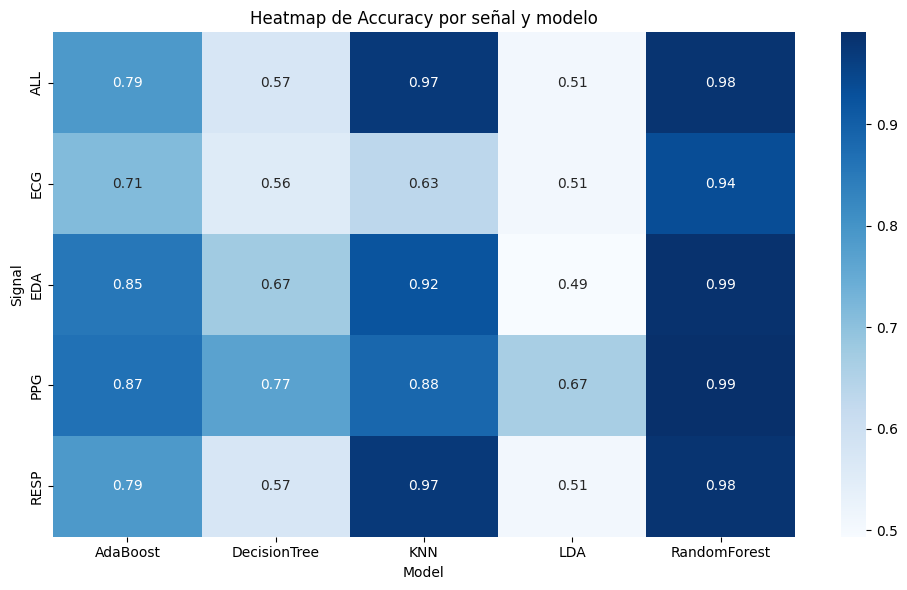

In [47]:
# Entrenamiento por cada tipo de señal
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject']  # Se agrega el identificador de sujetos para LOSO
        
        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal}...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics

# Entrenamiento con todas las señales combinadas
X_all = df.drop(columns=['label', 'subject'])  # También se excluye 'subject'
y_all = df['label']
subjects_all = df['subject']

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    acc = train_and_evaluate(X, y, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = acc

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}: {acc}')

rows = []

for (signal, model), df_metrics in results.items():
    # Convertimos el DataFrame a formato entendible
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo')
plt.tight_layout()
plt.show()

*RANDOM FOREST*

In [ ]:
param_gridrRD = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

randomfor_model = RandomForestClassifier(random_state=random)

print("Sin balanceo")
train_and_evaluate(randomfor_model, param_gridrRD, X_train, y_train, X_test, y_test)

*ADA BOOST*

In [ ]:
param_gridADA = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 58],
    'estimator__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
}

base_estimator = DecisionTreeClassifier(random_state=random)
adaboost_model = AdaBoostClassifier(estimator=base_estimator, random_state=random)

train_and_evaluate(adaboost_model, param_gridADA, X_train, y_train, X_test, y_test)

*KNN*

In [ ]:
param_gridKNN = {
    'n_neighbors': [2, 3, 4, 5, 8, 10, 12, 15, 18, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree']
}

knn_model = KNeighborsClassifier()

train_and_evaluate(knn_model, param_gridKNN, X_train, y_train, X_test, y_test)

*DECISION TREE*

In [ ]:
param_gridDT = {
    'criterion': ['gini', 'entropy'],  # Función para medir la calidad de una división
    'max_depth': [None, 3, 5, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 8],  # Muestras mínimas en una hoja
    'max_features': ['sqrt', 'log2', None]  # Número de características a considerar en cada división
}

decision_tree_model = DecisionTreeClassifier(random_state=random)

train_and_evaluate(decision_tree_model, param_gridDT, X_train, y_train, X_test, y_test)

*LDA*

In [ ]:
param_gridLDA = {
    'solver': ['lsqr', 'eigen'],  # Excluye 'svd'
    'shrinkage': ['auto', 0.1, 0.5, 1.0]  # Compatible con 'lsqr' y 'eigen'
}

lda_model = LinearDiscriminantAnalysis()

train_and_evaluate(lda_model, param_gridLDA, X_train, y_train, X_test, y_test)